[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/079_smith_hutton/079_smith_hutton.ipynb)

# Smith-Hutton Problem

En este post vamos a resolver el problema conocido como Smit-Hutton, en el que resolveremos la ecuación de convección 2D que ya conocemos del post anterior. 

$$
\phi_t + u \phi_x + v \phi_y = 0
$$

En este caso, tanto el dominio como las condiciones de contorno e inicial serán diferentes.

![](./sh.png)

Se trata de un dominio rectangular en el cual tenemos una entrada por la parte inferior izquierda y una salida por la parte inferior derecha. El campo inicial de $\phi$ estará a cero, por lo que el valor indicado a la entrada viajará hasta la salida debido al campo de velocidad circular definido. Ya que no hay viscosidad, deberíamos encontrar a la salida exactamente el mismo perfil que a la entrada. Este problem es muy útil para evaluar diferentes esquemas numéricos y sus propiedades.

# Métodos de Volúmenes Finitos

De la misma manera que hicimos en el post anterior, primero resolveremos el problema usando métodos de volúmenes finitos. Ahora, sin embargo, usaremos una formulación diferente y mucho más eficiente. En vez de calcular los flujos iterando nuestros arrays y haciendo los cálculos necesarios, usaremos productos de matrices y vectores.

In [8]:
import numpy as np
import math 

# condición inicial

Lx, Ly, Nx, Ny = 2., 1., 5, 5
dx, dy = Lx / Nx, Ly / Ny

x = np.linspace(-1+0.5*dx,1-0.5*dx,Nx) 
y = np.linspace(0.5*dy,1-0.5*dy,Ny) 
xx, yy = np.meshgrid(x, y)

p0 = np.zeros(Nx*Ny)

u = 2.*yy*(1.-xx**2.)
v = -2.*xx*(1.-yy**2.)


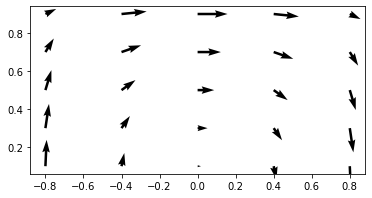

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.quiver(xx,yy,u,v)
ax.set_aspect('equal')
plt.show()

Lo primero que necesitamos es calcular el flujo de $\phi$ en cada cara. Para ello usaremos el esquema `CDS` visto en los posts anteriores, que simplemente aproxima el valor de $\phi$ en una cara como el promedio entre las celdas a ambos lados. Imaginemos que nuestro dominio tuviese solo 3 celdas en $x$. El siguiente producto matriz-vector nos daría el resultado que esperamos

$$
\begin{bmatrix}
0.5 & 0.5 & 0\\
0 & 0.5 & 0.5
\end{bmatrix}
\begin{pmatrix}
\phi_0 \\
\phi_1 \\ 
\phi_2
\end{pmatrix}
= 
\begin{pmatrix}
0.5(\phi_0 + \phi_1)\\
0.5(\phi_1 + \phi_2)
\end{pmatrix}
$$

In [20]:
def compute_flux_matrices(Nx, Ny, x, y):
    fx, fy = np.zeros((Ny*(Nx+1), Ny*Nx)), np.zeros(((Ny+1)*Nx, Ny*Nx))
    for i in range(Ny):
        for j in range(1, Nx):
            f = j + i*(Nx+1)
            c = j + i*Nx
            fx[f, c - 1] = 1.
            fx[f, c] = 0.
    for i in range(1,Ny):
        for j in range(Nx):
            f = j + i*Nx
            c = j + i*Nx
            vb = -2.*x[j]*(1.-y[i-1]**2.)
            vt = -2.*x[j]*(1.-y[i]**2.)
            vm = 0.5*(vt + vb)
            fy[f, c] = 1 if vm < 0 else 0
            fy[f, c - Nx] = 1 if vm >= 0 else 0
    return fx, fy

fx, fy = compute_flux_matrices(Nx, Ny, x, y)

In [21]:
u

array([[0.072, 0.168, 0.2  , 0.168, 0.072],
       [0.216, 0.504, 0.6  , 0.504, 0.216],
       [0.36 , 0.84 , 1.   , 0.84 , 0.36 ],
       [0.504, 1.176, 1.4  , 1.176, 0.504],
       [0.648, 1.512, 1.8  , 1.512, 0.648]])

In [22]:
fu = (fx @ u.ravel()).reshape(Ny,Nx+1)
fu

array([[0.   , 0.072, 0.168, 0.2  , 0.168, 0.   ],
       [0.   , 0.216, 0.504, 0.6  , 0.504, 0.   ],
       [0.   , 0.36 , 0.84 , 1.   , 0.84 , 0.   ],
       [0.   , 0.504, 1.176, 1.4  , 1.176, 0.   ],
       [0.   , 0.648, 1.512, 1.8  , 1.512, 0.   ]])

In [23]:
v

array([[ 1.584,  0.792, -0.   , -0.792, -1.584],
       [ 1.456,  0.728, -0.   , -0.728, -1.456],
       [ 1.2  ,  0.6  , -0.   , -0.6  , -1.2  ],
       [ 0.816,  0.408, -0.   , -0.408, -0.816],
       [ 0.304,  0.152, -0.   , -0.152, -0.304]])

In [24]:
fv = (fy @ v.ravel()).reshape(Ny+1,Nx)
fv

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 1.584,  0.792,  0.   , -0.728, -1.456],
       [ 1.456,  0.728,  0.   , -0.6  , -1.2  ],
       [ 1.2  ,  0.6  ,  0.   , -0.408, -0.816],
       [ 0.816,  0.408,  0.   , -0.152, -0.304],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

Una vez calculados los flujos tenemos que hacer su sumatorio para cada celda. De nuevo, lo haremos con un producto matriz-vector. 

$$
\begin{bmatrix}
1 & 1 & 0\\
0 & 1 & 1
\end{bmatrix}
\begin{pmatrix}
f_0 \\
f_1 \\ 
f_2
\end{pmatrix}
= 
\begin{pmatrix}
f_0 + f_1 \\
f_1 + f_2
\end{pmatrix}
$$

In [25]:
def compute_flux_sum_matrices(Nx, Ny):
    sx, sy = np.zeros((Ny*Nx, Ny*(Nx+1))), np.zeros((Ny*Nx, (Ny+1)*Nx))
    for i in range(Ny):
        for j in range(Nx):
            c = j + i*Nx
            f = j + i*(Nx+1)
            sx[c, f] = -1
            sx[c, f + 1] = 1
    for i in range(Ny):
        for j in range(Nx):
            f = j + i*Nx
            c = j + i*Nx
            sy[c, f] = -1
            sy[c, f + Nx] = 1
    return sx, sy

sx, sy = compute_flux_sum_matrices(Nx, Ny)

In [45]:
def run_sim(Nx, Ny, tf=1., cfl = 1., scheme='uds', a=10):
    Lx, Ly = 2., 1.
    dx, dy = Lx / Nx, Ly / Ny
    x = np.linspace(-1+0.5*dx,1-0.5*dx,Nx) 
    y = np.linspace(0.5*dy,1-0.5*dy,Ny) 
    xx, yy = np.meshgrid(x, y)
    p0 = np.zeros(Nx*Ny)
    u = 2.*yy*(1.-xx**2.)
    v = -2.*xx*(1.-yy**2.)
    ps = [p0]
    ts = [0]
    t = 0
    dt = 1e10
    for _u, _v in zip(u.ravel(), v.ravel()):
        dt = min(dt, cfl * min((Lx / Nx) / (abs(_u) + 1e-8), (Ly / Ny) / (abs(_v) + 1e-8)))
    print(dt)    
    h = dt/(dx*dy)    
    fx, fy = compute_flux_matrices(Nx, Ny, x, y)
    sx, sy = compute_flux_sum_matrices(Nx, Ny)    
    while t + dt < tf:
        t += dt        
        # euler
        rx = sx @ ((fx @ p0)*(fx @ u.ravel()))        
        Fy = (fy @ p0)*(fy @ v.ravel())
        for j in range(Nx):
            vb = -2.*x[j]
            if x[j] <= 0:    
                Fy[j] = vb*(1+np.tanh(a*(2*x[j]+1)))
            else:
                Fy[j] = vb*p0[j] 
        ry = sy @ Fy
        p = p0 + h*(dy*rx + dx*ry)
        # second order AB
        # fx, fy = compute_flux(p, u, v, scheme)
        # r0 = sum_fluxes(fx, fy)
        # p2 = update_p(p, r0, r, 1.5, -0.5, h)
        # ps.append(p2)
        ps.append(p)
        ts.append(t)
        p0 = p.copy()
    return ps, ts

In [46]:
from matplotlib import animation, rc
rc('animation', html='html5')

def update(i):
    ax.clear()
    p = ps[i]
    ax.imshow(p.reshape(Ny,Nx), vmin=p.min(), vmax=p.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f't = {ts[i]:.3f}')
    ax.axis('off')
    return ax

In [52]:
Nx, Ny = 60, 30

ps, ts = run_sim(Nx, Ny, tf=0.5, cfl=0.5)

0.008476930931119824


In [53]:
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(ps), interval=200)
plt.close()

anim

In [59]:
ps[9].max()

9.43885114649591